In [23]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from p24asolver import P24ASolver

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
class Planets(P24ASolver):
    """
    Simulate a system of two masses with dampers driven by a sinusoidal input
    """

    def __init__(self, **kwargs):
        """
        I'm going to use Python's keyword argument mechanism to handle the parameters.

        The kwargs parameter is a dictionary of all the named parameters and their values. We can use
        the built-in 'get' method to store parameter values, which allows us to provide default values
        in cases where no value was given.

        Note that we need to call the __init__ method of P24ASolver with a list of
        variable names. The first string in each variable tuple is the variable name, which you can use to
        refer to the variable, the second is a LaTeX representation that will look nice on a plot.
        """
        super().__init__(
            (('x1', '$x_1$'), ('v1', r'$\dot{x}_1$'),
             ('x2', '$x_2$'), ('v2', r'$\dot{x}_2$'))
        )
        # Now store variables, using defaults, if necessary
        self.JUPR = kwargs.get('JUPR', 1)
        self.JUPW = kwargs.get('JUPW', 1)
        self.JUPM = kwargs.get('JUPM', 1)
        self.SUNM = kwargs.get('SUNM', 1)
        self.G = 10000
        self.SATM = kwargs.get('SATM', 1)
        
    def __str__(self):
        "Produce a string representation of the parameters"
        fmt = r"$\mu = {0:.2g}, D = {1:.2g}, \zeta_1 = {2:.2g}, \zeta_2 = {3:.2g}$"
        return fmt.format(self.μ, self.D, self.ζ1, self.ζ2)

    def derivatives(self, t, Y):
        x1, v1, x2, v2 = Y  # unpack the values
        xj1, xj2 = self.orbit(JUPR, JUPW, t) #jup pos
        ####getting  radii from sun and jup respectively#####
        R_sun_sq = x1**2+x2**2
        R_jup_sq = (x1-xj1)**2 + (x2-xj2)**2
        #####################################################
        
        ######getting force due to sun and jup respectively##
        norm_pos = np.math.sqrt(x1**2+x2**2)
        
        F_sun_mag = (G*SUNM*SATM)/R_sun_sq
        F_sun = (F_sun_mag/norm_pos)*np.array([-x1,-x2])
        
        F_jup_mag = (G*JUPM*SATM)/R_jup_sq
        F_jup = (F_jup_mag/norm_pos)*np.array([xj1-x1,xj2-x2])  
        ###################################################### 
        
        ###############summing those up ##############
        F_tot = F_sun + F_jup
        
        F1, F2 = F_tot
        
        a1 = F1/SATM
        
        a2 = F2/SATM
        return [v1, a1, v2, a2]

    def orbit(self, R, w, t):
        """
        input: R is the average radius of the planet, t is the time passed, w is the angular speed of the planet
        output: returns the position of the planet at time t given 
        """
        return (R*np.math.cos(w*t), R*np.math.sin(w*t))
    
    def prepare_figure(self):
        """
        Function that creates the figure and axes for the animation.
        """

        fig, ax = plt.subplots(figsize=(12, 2.5))
        # We need to set the axes limits so each frame uses the same limits
        # I'll say that the center position of the first mass is at 2 and the second at 4
        ax.set_xlim((0, 14))
        ax.set_ylim((-0.2, 0.7))

        self.lines = [ax.plot([], [], 'k-')[0] for n in range(3)]
        self.planets = [Rectangle((x, 0), 1, 0.5, color='r')
                      for x in (1.5, 4.5)]
        self.planets.append(Circle((12, 0.25), radius=0.1, color='g'))
        for c in self.planets:
            ax.add_patch(c)
        return fig, ax

    def draw_frame(self, t):
        """
        Draw frame for time t
        """
        pass 

In [25]:
P = Planets()
P.orbit(10,1,2)

(-4.161468365471424, 9.092974268256818)

<IPython.core.display.Javascript object>


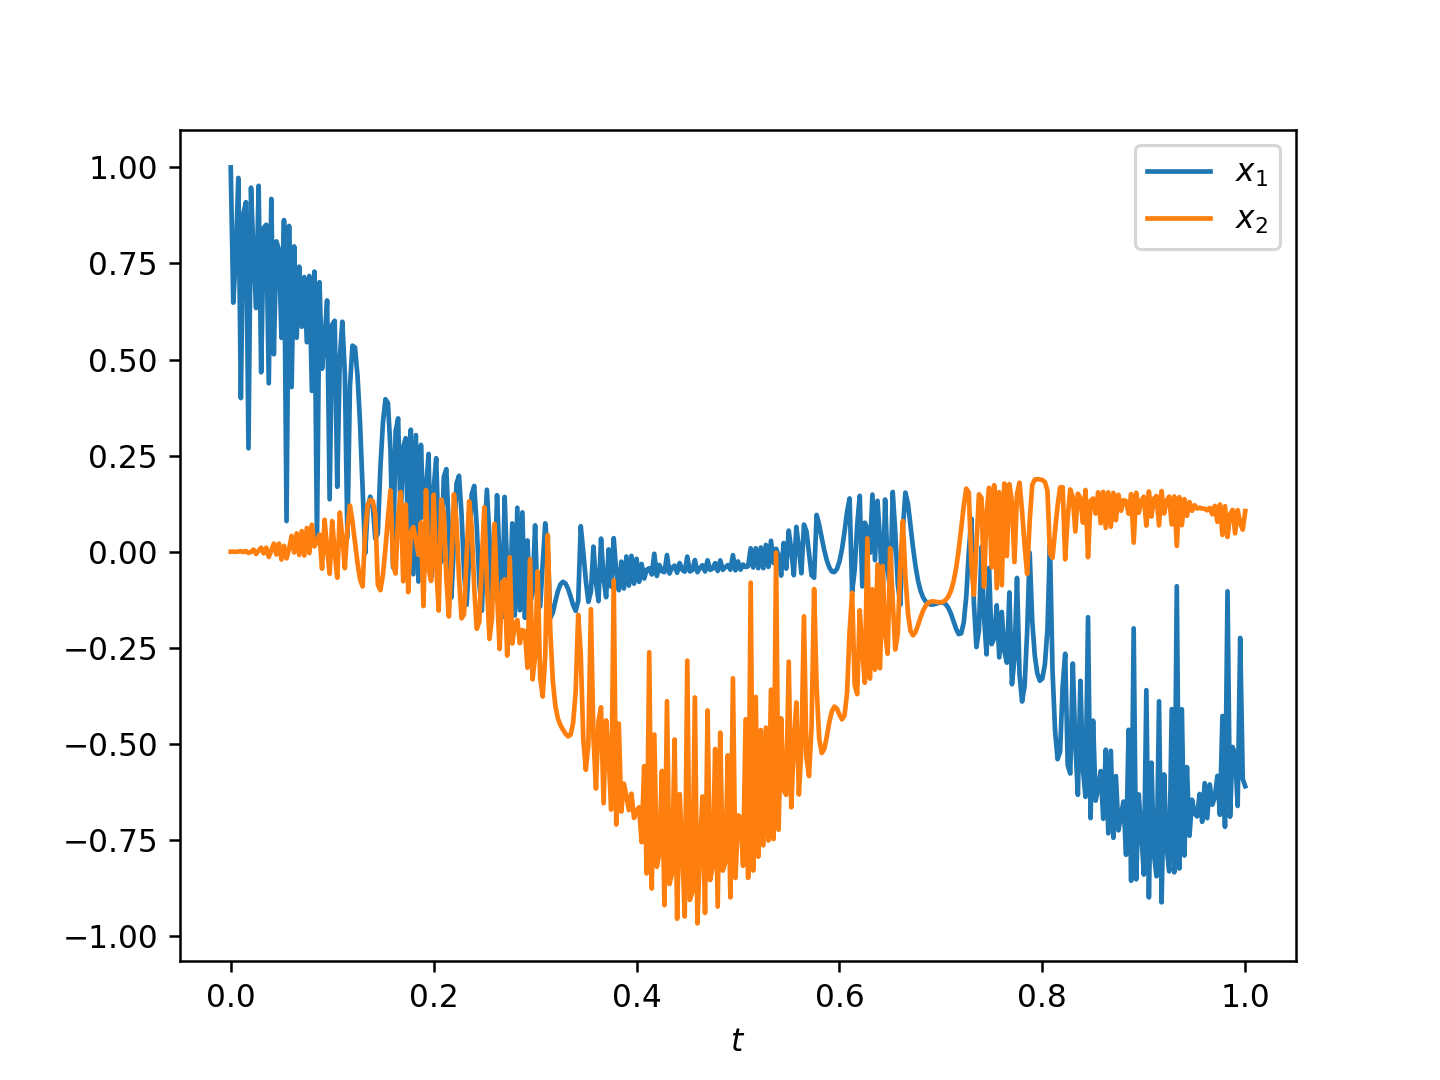

In [44]:
rest = (1,0,0,.1)
times = np.linspace(0, 1, 401)
sol1 = Planets(JUPR = 5.2, JUPW = 2*np.pi/12, JUPM = .000955, SUNM = 1, SATM = 2.2268*10**(-31)).solve(rest, (0,1)).plot(times, ['x1', 'x2'])

In [36]:
sol1

In [18]:
sol1.animate(200);

<IPython.core.display.Javascript object>

In [11]:
sol2 = Carts(mu=1, Omega=1.4, D=0.2).solve(rest, (0,20)).plot(times, ['x1', 'x2']);

<IPython.core.display.Javascript object>

That's interesting. When $\Omega = 1$, the two masses appear to be moving with about the same phase, but when $\Omega = 1.4$, mass 1 lags behind mass 2 by almost 90°. 

In [12]:
sol3 = Carts(mu=1, Omega=2).solve(rest, (0,20)).plot(times, ['x1', 'x2'], figsize=(8,5));

<IPython.core.display.Javascript object>

Another interesting development: at $\Omega = 2$ the amplitude of motion of mass 1 is now smaller than the amplitude for mass 2. We should prepare a plot of the amplitude and phase of each cart's motion with respect to the drive as a function of frequency. We could do that simulating for a while and then looking at the oscillations at the end of the run.

In [13]:
def find_amplitude_and_phase(**kwargs):
    t_max = 49.750
    sol = Carts(**kwargs)
    sol.solve((0,0,0,0), (0, t_max))
    # Now we need to extract the amplitude and phase for x1 and x2
    # We can do that by restarting the solution using the end point as the initial condition
    Y0 = sol(t_max)
    period = 2 * np.pi / sol.ω
    t_range = (t_max, t_max + 1.5 * period)
    sol2 = Carts(**kwargs)
    sol2.events = [lambda t, Y, args: Y[0], lambda t, Y, args: Y[2]]
    sol2.solve(Y0, t_range)
    t0 = period * np.floor(t_max / period)
    try:
        t1 = sol2.solution.t_events[0][0]
    except:
        print(sol2.solution)
    def adjust_phase(ϕ):
        two_pi = 2 * np.pi
        while ϕ > 0: ϕ -= two_pi
        while ϕ < -two_pi: ϕ += two_pi
        return ϕ
            
    ϕ1 = (t0 - t1) * sol2.ω + (0 if sol2.solution.y_events[0][0,1] > 0 else np.pi)
    A1 = np.abs(sol2(t1 + 0.25 * period)[0])
    t2 = sol2.solution.t_events[1][0]
    ϕ2 = (t0 - t2) * sol2.ω + (0 if sol2.solution.y_events[1][0,3] > 0 else np.pi)
    A2 = np.abs(sol2(t2 + 0.25 * period)[2])
    return (A1, adjust_phase(ϕ1), A2, adjust_phase(ϕ2))

In [14]:
find_amplitude_and_phase(Omega=1.4)

(1.0015394961130448,
 -3.1303752816674857,
 0.28327815632526754,
 -1.7014757270294423)

In [15]:
Omegas = 10**np.linspace(-1,1,101)
results = np.array([find_amplitude_and_phase(Omega=x) for x in Omegas])

KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
amps, phases = axes
amps.loglog(Omegas, results[:,0], label=r'$|A_1|$')
amps.loglog(Omegas, results[:,2], label=r'$|A_2|$')
amps.set_xlabel(r"$\omega/\omega_0$")
amps.legend()
amps.grid()
phases.semilogx(Omegas, np.degrees(results[:,1]), label=r'$\phi_1$')
phases.semilogx(Omegas, np.degrees(results[:,3]), label=r'$\phi_2$')
phases.legend()
phases.set_yticks(np.linspace(-360, 0, 5))
phases.grid()
phases.set_xlabel(r"$\omega/\omega_0$");

Very interesting! We see two resonance peaks in the motion of the two carts: one at $\Omega = \omega/\omega_0 = 1$ and one at $\Omega \approx 1.7$. Let's zoom in a make a close-up plot of this interesting region.

In [ ]:
Omegas2 = np.linspace(0.8,2,101)
results = np.array([find_amplitude_and_phase(Omega=x) for x in Omegas2])
fig, axes = plt.subplots(2, 1, figsize=(8,8), sharex=True)
amps, phases = axes
amps.semilogy(Omegas2, results[:,0], label=r'$|A_1|$')
amps.semilogy(Omegas2, results[:,2], label=r'$|A_2|$')
amps.legend()
phases.plot(Omegas2, np.degrees(results[:,1]), label=r'$\phi_1$')
phases.plot(Omegas2, np.degrees(results[:,3]), label=r'$\phi_2$')
phases.legend()
phases.set_yticks(np.linspace(-360,0,5))
phases.grid()
phases.set_xlabel(r"$\omega/\omega_0$");

Can you explain this behavior?

Other things to explore:
- Can you calculate an analytic solution and compare it with the numerical results?
- Does it matter which cart has the damper?
- What does the phase plot tell us?
- How does the mass ratio influence the plots?
- ...

# Animation

Let’s see if we can't animate the motion of the carts. We will need to figure out how to show the two carts and drive. If we’re hard core, we may also figure out how to draw the springs. Rather than replacing the old class, I'll just define a new one here. Not sure why!

In [ ]:
csol = Carts(mu=1, Omega=2)
csol.solve((0,0,0,0), (0, 10))
tvals = np.linspace(0, 10, 400)
csol.plot(tvals, ['x1', 'x2']);

In [ ]:
csol.animate(300, time_range=(0,10));

In [ ]:
csol2 = Carts(mu=1, Omega=1.41).solve((0,0,0,0),(0, 10)).plot(np.linspace(0, 10, 400), ['x1', 'x2']);

In [ ]:
plt.close('all')
csol2.animate(300, time_range=(0, 10));